In [11]:
import sys
sys.path.append("C:/Users/vinit/Downloads/Research/Quantum-Sampling")
from Sampling import *
from RBM import *
from spin_utils import *
from Adam import Adam

import numpy as np
import time
import matplotlib.pyplot as plt
import json
from functools import partial
import re
import pickle


In [12]:
N=6
M=4
D=0
beta=1.0

In [13]:

Ham = np.zeros((2**N,2**N),dtype=complex)

with open('gamma_Hk.txt', 'r') as f:
    for line in f:
        # Match lines like: m= 1 n= 2 Re=0.0000000000 Im=0.0000000000
        match = re.match(r"m=\s*(\d+)\s*n=\s*(\d+)\s*Re=([-\d\.]+)\s*Im=([-\d\.]+)", line)
        if match:
            m, n, re_val, im_val = match.groups()
            Ham[int(m)-1,int(n)-1] = float(re_val) + 1j * float(im_val)


In [14]:
Ham_Pauli = hamiltonian_matrix_to_pauli_sum(Ham)

In [15]:
# Adam optimizer hyperparameters
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [30]:
data_dir = "Data/LiCoO_k=33/"

# create a folder prob_dict inside the data_directory if it doesn't exist 


In [31]:
from scipy.sparse import csr_array, coo_matrix
from scipy.sparse.linalg import eigsh

Ham_csr = csr_array(Ham)
lmbd, _ = eigsh(Ham_csr, k=1, which='SA')

print("Ground State:", lmbd)

Ground State: [-1.31548292e-15]


In [32]:
def plot_log(E_hist=[], E_smpl_hist=[], lmbd=None):
    if len(E_smpl_hist) == 0:
        plt.plot(E_hist)
        plt.ylabel("Energy")
        plt.xlabel("Epochs")

    elif len(E_hist) == 0:
        plt.plot(E_smpl_hist)
        plt.ylabel("Energy")
        plt.xlabel("Epochs")

    else: 
        ya = np.real(E_hist)
        xa = np.arange(len(ya))
        ci = np.abs(np.array(E_smpl_hist) - ya)
        _, ax = plt.subplots()
        ax.plot(ya)
        ax.fill_between(xa, (ya-ci), (ya+ci), color='r', alpha=.5)
        ax.set_ylabel("Energy")
        ax.set_xlabel("Epochs")

    if lmbd:
        plt.hlines(lmbd[0],0,len(E_hist)-1,color='r',linestyles='dashed')

In [44]:
def save_data(data_dir,X,E=None,E_smpl=None):
  with open(data_dir+"X.txt", "ab") as f:
    np.savetxt(f, np.reshape(X,(1,-1)))
  if E is not None:
    with open(data_dir+"E.txt", "ab") as f:
      np.savetxt(f, [E])
  elif E_smpl is not None:
    with open(data_dir+"E_smpl.txt", "ab") as f:
      np.savetxt(f, [E_smpl])

0 Energy:  3.6995498837356835
1 Energy:  3.3685962723900635
2 Energy:  3.0723766668512273
3 Energy:  2.7973127579620845



Energy:  2.7973127579620845 
 Time 52.688416957855225 -1.3154829242968974e-15


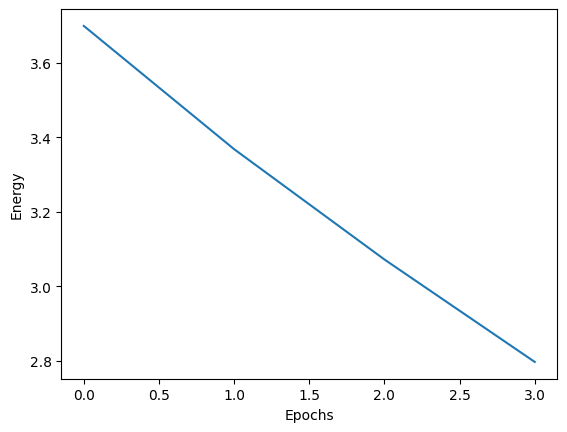

In [45]:
sample_size = 20000
method = "exact"  # "exact" or "sampling"

seed = 1

E_hist=[]
E_smpl_hist=[]

rbm = RBM(N,M,seed=seed)
X = rbm.X

tm=time.time()

optimizer = Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

for epoch in range(4):
  rbm = RBM(N,M,X=X)

  params = [rbm.a, rbm.b, rbm.w]
  #tm = time.time()
  prob_func = partial(prob_RBM_nv, params=params)
  if method == "sampling":
    prob_dict = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
    with open(data_dir+"prob_dict/epoch_"+str(epoch)+".pkl", "wb") as f:
      pickle.dump(prob_dict, f)
  #print("Sampling Time: ", time.time()-tm)

  if method == "exact":
    E = rbm.Energy_exact(Ham_Pauli)
    print(epoch, "Energy: ", E)
    grad = np.real(rbm.grad_exact(Ham_Pauli))
    E_hist.append(E)
    save_data(data_dir,X,E)
    

  elif method == "sampling":
    E_smpl = rbm.Energy_sampling(Ham_Pauli,prob_dict=prob_dict)
    grad = np.real(rbm.grad_Sampling(Ham_Pauli,prob_dict=prob_dict))
    E_smpl_hist.append(E_smpl)

    E = None
    if N < 10:
      E = rbm.Energy_exact(Ham_Pauli)
      print(epoch, "Energy: ", E, "\t +/- \t", np.abs(E_smpl - E))
      E_hist.append(E)
    save_data(data_dir,X,E,E_smpl)
    

  optimizer.apply_gradients([(grad, rbm.X)])

if E: 
  print("\n\n\nEnergy: ",E,"\n Time",time.time()-tm, lmbd[0])
else: 
  print("\n\n\nEnergy: ",E_smpl,"\n Time",time.time()-tm, lmbd[0])


plot_log(E_hist, E_smpl_hist)


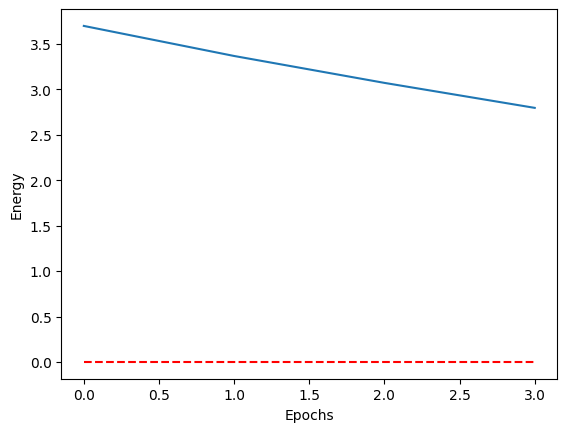

In [46]:
plot_log(E_hist, E_smpl_hist, lmbd)